In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(u'fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import minepy
from kaggle.zillow.pysrc.data_load import *
from kaggle.zillow.pysrc.data_clean import *

In [2]:
load = Load()

featinfo = load.load_featinfo()
feat = load.load_property()
submission = load.load_submission()
train = load.load_train()

load featureInfo.csv ..
featinfo datashape: 58 X 7 ,cost time: 0.00s
load properties_2016.csv ..
properties datashape: 2985217 X 58 ,cost time: 17.23s
load sample_submission.csv ..
submission datashape: 2985217 X 7 ,cost time: 1.45s
load train.csv ...
train datashape: 90275 X 3 ,cost time: 0.08s


In [3]:
feat = clean_flow(feat)

extract nannum feat ...
------  cost time 4.99 seconds
binary feature clean ...
convert H_deck
convert F_pool2
convert F_pool2
convert N_pool
convert H_spaId
convert H_pool2
convert H_pool7
convert H_floor
convert F_fireplace
convert F_fireplace
convert T_taxunpaid
------  cost time 10.60 seconds
drop_same_feature ...
leave feature:N_unit ,drop feature: H_style
leave feature:N_bathroom1 ,drop feature: N_bathroom2
leave feature:A_living1 ,drop feature: A_living2
leave feature:A_living1 ,drop feature: A_perimeter
leave feature:A_living1 ,drop feature: A_total
leave feature:A_living1 ,drop feature: A_base
leave feature:P_check1 ,drop feature: G_fips
------  cost time 106.84 seconds


## logerror

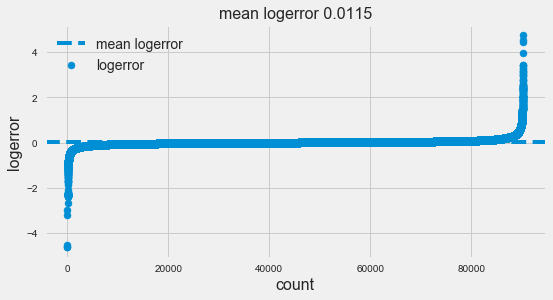

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(range(train.shape[0]), np.sort(train.logerror.values),label='logerror')
ax.set_ylabel('logerror',size=16)
ax.set_xlabel('count',size=16)
ax.axhline(train.logerror.mean(),linestyle='--',label='mean logerror')
ax.legend(fontsize=14)
ax.set_title('mean logerror %.4f'%(train.logerror.mean()), size=16)

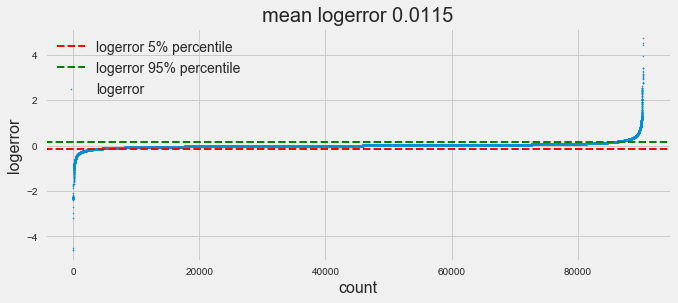

In [34]:
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(range(train.shape[0]), np.sort(train.logerror.values),label='logerror', s=1)
ax.set_ylabel('logerror',size=16)
ax.set_xlabel('count',size=16)
ax.axhline(np.percentile(train.logerror, 5),linestyle='--',label='logerror 5% percentile', c='r', linewidth=2)
ax.axhline(np.percentile(train.logerror, 95),linestyle='--',label='logerror 95% percentile', c='g',linewidth=2)
ax.legend(fontsize=14)
ax.set_title('mean logerror %.4f'%(train.logerror.mean()), size=20)

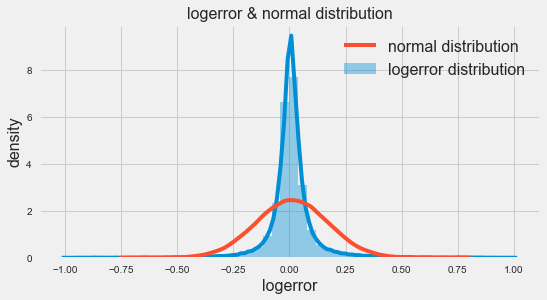

In [21]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(train.logerror.where((train.logerror<1)&(train.logerror>-1)).dropna(),label='logerror distribution')
sns.distplot(sp.stats.norm.rvs(sp.stats.tmean(train.logerror), 
                  sp.stats.tstd(train.logerror),
                  size=train.shape[0]), hist=False, label='normal distribution')
ax.set_xlabel('logerror', size=16)
ax.set_ylabel('density', size=16)
ax.legend(fontsize=16)
ax.set_title('logerror & normal distribution', size=16)

In [22]:
(train.groupby(np.sign(train.logerror))['logerror'].agg(['count','mean','std','min','max','median']))\
.rename(index={-1:'negative logerror',0:'zero logerror',1:'positive logerror'})

,count,mean,std,min,max,median
logerror,,,,,,
negative logerror,39667,-0.064849,0.134954,-4.605,-0.001,-0.0315
zero logerror,847,0.000000,0.000000,0.000,0.000,0.0000
positive logerror,49761,0.072480,0.155518,0.001,4.737,0.0344


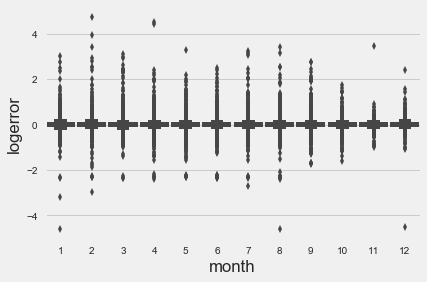

In [30]:
train['month'] = train.transactiondate.dt.month
sns.boxplot(x='month',y='logerror',data=train)

## nan feature

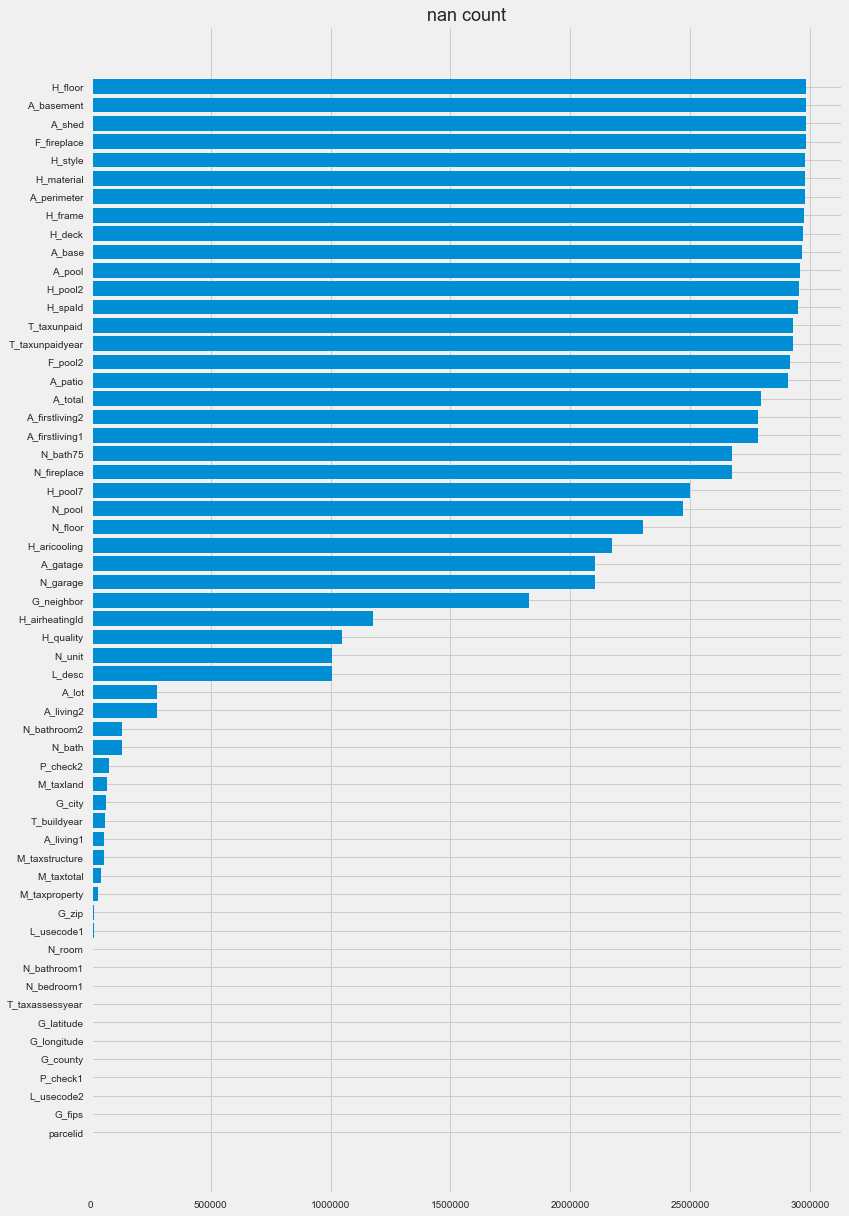

In [49]:
nan_count = feat.isnull().sum().sort_values()
fig, ax = plt.subplots(figsize=(12,20))
ax.barh(range(len(nan_count)),nan_count)
ax.set_yticks(range(len(nan_count)))
ax.set_yticklabels(nan_count.index)
ax.set_title('nan count', size=18)

## nan faeture

In [ ]:
df = pd.merge(train, feat, on='parcelid', how='left')

df['abslogerror'] = df.logerror.abs()

In [64]:
for i in ['A','H','P','T','N','G','M']:
    cols = [c for c in df.columns if i in c]
    df['*%s_nannum'%i] = df[cols].T.isnull().sum()

df['*total_nannum'] = df[[c for c in df.columns if 'nannum' in c]].sum(axis=1)

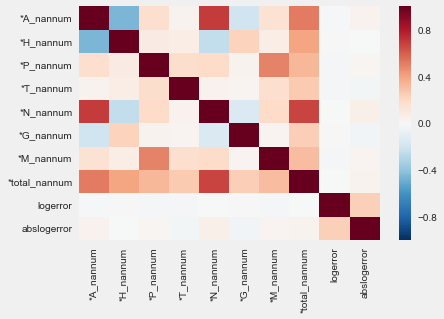

In [79]:
sns.heatmap(df[[c for c in df.columns if 'nannum' in c]+['logerror','abslogerror']].corr())

In [85]:
mine = minepy.MINE()
nannumfeat_infocoef = {}
for c in df.columns:
    if 'nannum' in c:
        mine.compute_score(df[c],df['logerror'])
        nannumfeat_infocoef[c] = mine.mic()

In [91]:
sorted(nannumfeat_infocoef.items(), key=lambda x: x[1], reverse=True)

[('*A_nannum', 0.019567212677019136),
 ('*N_nannum', 0.017408838084552795),
 ('*H_nannum', 0.015542852979251046),
 ('*G_nannum', 0.015500845101908498),
 ('*total_nannum', 0.012721542748454193),
 ('*T_nannum', 0.01233034387420951),
 ('*M_nannum', 0.007337417190811023),
 ('*P_nannum', 0.0071345130085772165)]

In [95]:
np.log1p(-1)

/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log1p
  """Entry point for launching an IPython kernel.


-inf

In [96]:
df.columns

Index(['parcelid', 'logerror', 'transactiondate', 'month', 'H_aricooling',
       'H_style', 'A_basement', 'N_bathroom1', 'N_bedroom1', 'H_frame',
       'H_quality', 'N_bathroom2', 'H_deck', 'A_firstliving1', 'A_living1',
       'A_living2', 'A_perimeter', 'A_total', 'A_firstliving2', 'A_base',
       'G_fips', 'N_fireplace', 'N_bath', 'N_garage', 'A_gatage', 'F_pool2',
       'H_airheatingId', 'G_latitude', 'G_longitude', 'A_lot', 'N_pool',
       'A_pool', 'H_spaId', 'H_pool2', 'H_pool7', 'L_usecode1', 'L_usecode2',
       'L_desc', 'P_check1', 'G_city', 'G_county', 'G_neighbor', 'G_zip',
       'N_room', 'H_floor', 'N_bath75', 'H_material', 'N_unit', 'A_patio',
       'A_shed', 'T_buildyear', 'N_floor', 'F_fireplace', 'M_taxstructure',
       'M_taxtotal', 'T_taxassessyear', 'M_taxland', 'M_taxproperty',
       'T_taxunpaid', 'T_taxunpaidyear', 'P_check2', '*A_nannum', '*H_nannum',
       '*P_nannum', '*T_nannum', '*N_nannum', '*G_nannum', '*M_nannum',
       'abslogerror', '*total

In [99]:
def ex_nannum_feat(df):
    nannum_feat = pd.DataFrame()
    for i in ['A','H','P','T','N','G','M']:
        cols = [c for c in df.columns if i in c]
        nannum_feat['*%s_nannum'%i] = df[cols].T.isnull().sum()
    nannum_feat['*total_nannum'] = nannum_feat.sum(axis=1)
    return nannum_feat

In [101]:
from sklearn.feature_selection import VarianceThreshold

In [126]:
sel = VarianceThreshold()

In [120]:
df.head()

,parcelid,logerror,transactiondate,month,H_aricooling,H_style,A_basement,N_bathroom1,N_bedroom1,H_frame,...,P_check2,*A_nannum,*H_nannum,*P_nannum,*T_nannum,*N_nannum,*G_nannum,*M_nannum,abslogerror,*total_nannum
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,...,6.037107e+13,10,8,0,2,5,0,0,0.0276,25
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,9,11,1,2,4,1,0,0.1684,28
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,...,6.037464e+13,10,8,0,2,5,0,0,0.0040,25
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,...,6.037296e+13,10,8,0,2,5,0,0,0.0218,25
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,...,6.059042e+13,9,10,0,2,2,1,0,0.0050,24


In [121]:
for c in df.columns:
    if df[c].dtype == float:
        df[c] = df[c].astype(np.float32)

In [122]:
col = [c for c in df.columns if (df[c].dtype == 'float')|(df[c].dtype == 'int')]

In [127]:
sel.fit_transform(df[col]).shape

(90275, 10)

In [128]:
df.shape

(90275, 70)

In [129]:
sel

VarianceThreshold(threshold=0.0)

In [133]:
df.head()

,parcelid,logerror,transactiondate,month,H_aricooling,H_style,A_basement,N_bathroom1,N_bedroom1,H_frame,...,P_check2,*A_nannum,*H_nannum,*P_nannum,*T_nannum,*N_nannum,*G_nannum,*M_nannum,abslogerror,*total_nannum
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,...,6.037107e+13,10,8,0,2,5,0,0,0.0276,25
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,9,11,1,2,4,1,0,0.1684,28
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,...,6.037464e+13,10,8,0,2,5,0,0,0.0040,25
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,...,6.037296e+13,10,8,0,2,5,0,0,0.0218,25
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,...,6.059042e+13,9,10,0,2,2,1,0,0.0050,24


In [145]:
cols = df.columns

In [150]:
df = pd.DataFrame({'a':[1,2],'b':[2,3],'c':[4,5]})

In [151]:
cols = df.columns

In [169]:
feat.H_floor.var()

0.0

In [171]:
df.drop('a',axis=1)

,b,c
0,2,4
1,3,5


In [172]:
from sklearn.preprocessing import MinMaxScaler

In [173]:
minmaxscaler = MinMaxScaler()

In [185]:
feat.fillna(np.nan, inplace=True)

In [176]:
df

array([[ 0.,  0.,  0.],
       [ 1.,  1.,  1.]])